# CS211: Data Privacy
## Homework 3

In [1]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from unittest.mock import patch

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

adult = pd.read_csv('https://github.com/jnear/cs211-data-privacy/raw/master/homework/adult_with_pii.csv')
adult = adult.dropna()

In [2]:
adult.head()

,Name,DOB,SSN,Zip,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,Karrie Trusslove,9/7/1967,732-14-6110,64152,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,Brandise Tripony,6/7/1988,150-19-2766,61523,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,Brenn McNeely,8/6/1991,725-59-9860,95668,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,Dorry Poter,4/6/2009,659-57-4974,25503,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,Dick Honnan,9/16/1951,220-93-3811,75387,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Question 1 (10 points)

Write code to answer the query: "how many participants have never been married?"

*Hint*: filter the `adult_data` dataframe to contain only participants who were never married, then return the  `len` of the filtered dataframe.

In [5]:
def query1():
    return len(adult[adult['Marital Status'] == 'Never-married'])

query1()

9726

In [6]:
# TEST CASE for question 1
assert query1() == 9726

## Question 2 (5 points)

In 2-5 sentences, answer the following:
- What is the sensitivity of `query1`, and why?

1
Counting queries always have a sensitivity of 1. adding a row will change the output my at most one

## Question 3 (10 points)

Use the implementation of `laplace_mech` to produce a differentially private answer to `query1`, with `epsilon = 0.1`.

In [23]:
COUNTING_SENSITIVITY = 1
def dp_query1(epsilon):
    return laplace_mech(query1(), COUNTING_SENSITIVITY, epsilon)

dp_query1(0.1)

9710.454365478825

In [8]:
# TEST CASE for question 3
dp_results = [dp_query1(0.1) for _ in range(100)]
spec = [np.random.laplace(loc=9726, scale=1/0.1) for _ in range(100)]
assert stats.wasserstein_distance(dp_results, spec) < 10

## Question 4 (10 points)

The `pct_error` function, defined below, returns the percent relative error between an original query result and a differentially private result for the same query.

Implement a function `graph_error1` that:

- Calculates 1000 differentially private answers to `dp_query1`
- Calculates the percent error for each one of these answers against the original (non-private) answer
- Graphs the distribution of errors using a histogram

*Hint*: use `plt.hist(..., bins=20)`.

The given code will use your function to plot errors for `epsilon=0.1` and `epsilon=1.0`.

In [9]:
def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

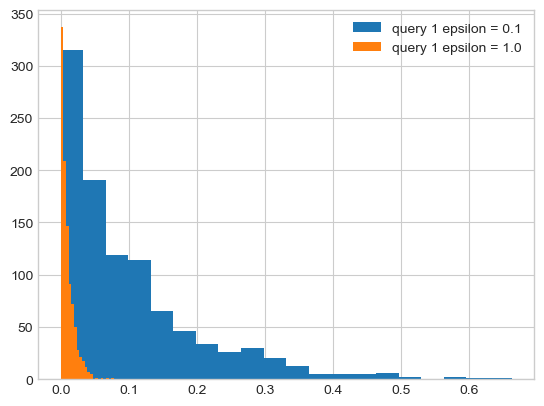

In [34]:
def graph_error1(epsilon):
    q1a = query1()
    errors = [pct_error(dp_query1(epsilon), q1a) for _ in range(1000)]
    plt.hist(errors, bins=20, label=f"query 1 epsilon = {epsilon}")
    plt.legend()

graph_error1(0.1)
graph_error1(1.0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


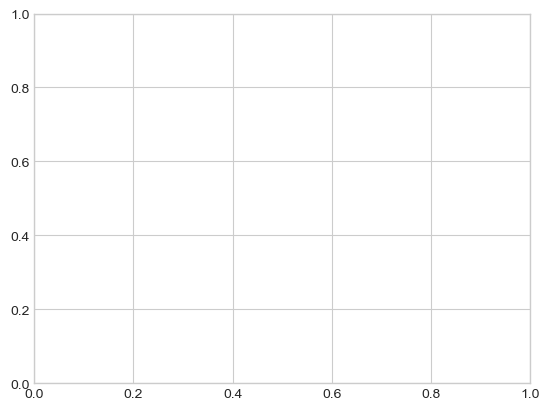

In [35]:
error_spec = 100.0 * np.abs(np.random.laplace(loc=0, scale=1, size=1000)) / query1()

with patch('matplotlib.pyplot.hist') as mock_hist:
    graph_error1(1.0)
    
args, kwargs = mock_hist.call_args
assert stats.wasserstein_distance(error_spec, args[0]) < 0.001

## Question 5 (10 points)

In 2-5 sentences, answer the following:

- How does the histogram of relative errors for $\epsilon = 0.1$ differ from the one for $\epsilon = 1.0$?
- What do the two histograms tell you about the effect of $\epsilon$ on relative error?

**HINT**: Pay close attention to which color represents which value of $\epsilon$!

Relative errors are larger for 0.1, because a lower epsilon denotes more privacy. Relative error is a measure of how incorrect the output is, so we would expect it to be larger if we wanted to obscure the correct answer more.

## Question 6 (10 points)

Consider `query2`, which asks how many people in the dataset are over the age of 60.

In [37]:
def query2():
    return len(adult[adult['Age'] > 60])

query2()

1806

Implement `dp_query2`, a differentially private version of `query2` (as in question 3), and `graph_error2`, which graphs relative error for `dp_query2` (as in question 4).

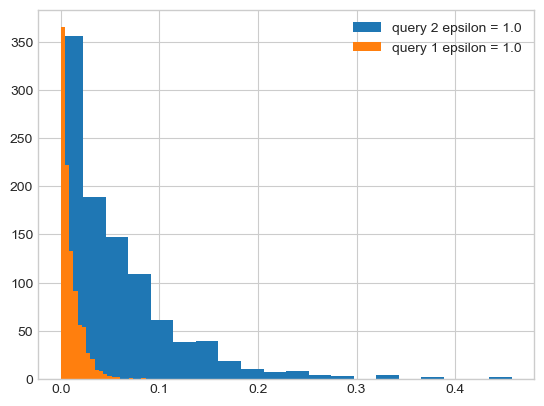

In [36]:
def dp_query2(epsilon):
    return laplace_mech(query2(), COUNTING_SENSITIVITY, epsilon)

def graph_error2(epsilon):
    q2a = query2()
    errors = [pct_error(dp_query2(epsilon), q2a) for _ in range(1000)]
    plt.hist(errors, bins=20, label=f"query 2 epsilon = {epsilon}")
    plt.legend()

graph_error2(1.0)
graph_error1(1.0) # we plot both errors for query 1 and query 2 at the same epsilon, to compare

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


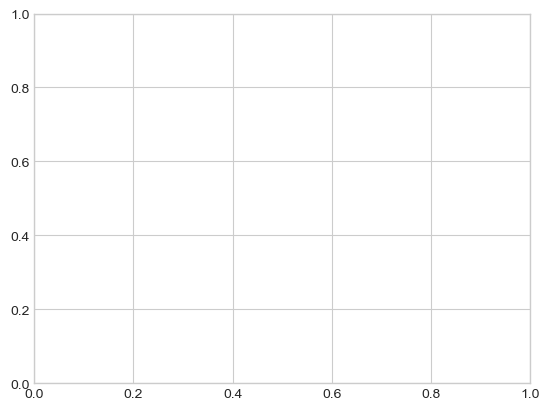

In [25]:
error_spec = 100.0 * np.abs(np.random.laplace(loc=0, scale=1, size=1000)) / query2()

with patch('matplotlib.pyplot.hist') as mock_hist:
    graph_error2(1.0)
    
args, kwargs = mock_hist.call_args
assert stats.wasserstein_distance(error_spec, args[0]) < 0.01

## Question 7 (10 points)

In 2-5 sentences, answer the following:

- Given the graph from question 6, how does relative error differ between `dp_query1` and `dp_query2` for the same value of $\epsilon$?
- What property of the query causes the difference in relative errors between `dp_query1` and `dp_query2`?

Relative error means relative to the size of the real answer. Because there are several times more unmarried people than there are people over 60, the laplace noise is drowned out more by the unmarried people, since it is absolute, it does not scale with the size of the input. This is why query 1 has much smaller relative error overall. We would expect in the extreme case, that if we had one query with answer 1 and one query with answer 1000, and we added the same noise of 10 to each, 11 is relatively very far from 1, but 1010 is relatively close to 1000.